# Import data & libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import collections

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv('train.csv')
data.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [3]:
data_test = pd.read_csv('test.csv')
data_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Training Data exploratory

## basic

In [4]:
print(f'n_observations : {len(data)}')
print(f"natural disaster spotted : {data['target'].sum()}")

n_observations : 7613
natural disaster spotted : 3271


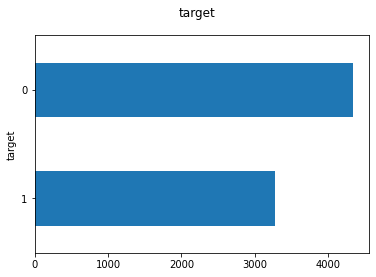

In [5]:
# Check if the data is balanced between targets
fig, ax = plt.subplots()
fig.suptitle('target', fontsize=12)
data['target'].reset_index().groupby('target').count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax)
plt.show()

## on 'location' column

In [6]:
data['location'].value_counts()

USA                      104
New York                  71
United States             50
London                    45
Canada                    29
                        ... 
Depok                      1
Hinterestland              1
NY || live easy?           1
VÌ_a LÌÁctea               1
WestEnd, Puritan Ave       1
Name: location, Length: 3341, dtype: int64

In [7]:
data.groupby(data['location'])['target'].sum().sort_values(ascending=False)

location
USA                            67
United States                  27
Nigeria                        22
India                          20
Mumbai                         19
                               ..
Korea                           0
University of Toronto           0
University of South Florida     0
Kuala Lumpur, Malaysia          0
Mid West                        0
Name: target, Length: 3341, dtype: int64

 ### 🌩  `Warning`
it seems to have more than a half of the USA location that are targeted with one. It can introduce a biais. Therefore this column will be removed to avoid over prediction on USA-location to come

## on 'keyword' column

In [8]:
tp = data['keyword'].value_counts().sort_index()
tp

ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
ambulance              38
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Name: keyword, Length: 221, dtype: int64

In [9]:
temporary = data.groupby(data['keyword'])['target'].sum()
temporary

keyword
ablaze                 13
accident               24
aftershock              0
airplane%20accident    30
ambulance              20
                       ..
wounded                26
wounds                 10
wreck                   7
wreckage               39
wrecked                 3
Name: target, Length: 221, dtype: int64

In [10]:
# Check the number of keyword with 100% of targetting
tpp = pd.concat((tp,temporary),axis=1)
tpp['%'] = tpp['target']/tpp['keyword']
tpp[tpp['%'] == 1]

,keyword,target,%
keyword,,,
debris,37,37,1.0
derailment,39,39,1.0
wreckage,39,39,1.0


In [11]:
# Check the number of keyword with less than 30% of targetting
len(tpp[tpp['%'] < 0.3])/len(tpp)

0.42081447963800905

 ### 🌨  Warning
 On the 221 unique keywords only 3 have are always targetted as a natural disaster. And more than 42% are target less than every 3 times. This is not enough for the keywords to be relevant for our model. Therefore this column will be removed

# Preprocess data

## Clean text

In [12]:
import string
from nltk.corpus import stopwords

def preprocess(text, lower_= True, punctuation=True, number=True, stopwords_=True, language='english'):

  if lower_:
    text = text.lower()
  if punctuation:
    text = (word for word in text if word not in string.punctuation)
  if number:
    text = ''.join(word for word in text if not word.isdigit())
  if stopwords_:
    text = text.split()
    stop_words = set(stopwords.words(language))
    text = ' '.join([word for word in text if word not in stop_words])

  return text
    

In [13]:
data['clean_text'] = data['text'].apply(preprocess)
data.head(2)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada


## Lemmatize text

In [14]:
from nltk.stem import WordNetLemmatizer

In [15]:
def lemmatizerer(text):
  lemmatizer = WordNetLemmatizer()
  text = text.split()
  lemmatized = [lemmatizer.lemmatize(word) for word in text]
  text = ' '.join(lemmatized)
  return text

In [16]:
data['lem_text'] = data['clean_text'].apply(lemmatizerer)
data.tail()

,id,keyword,location,text,target,clean_text,lem_text
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...,two giant crane holding bridge collapse nearby...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fires cali...,ariaahrary thetawniest control wild fire calif...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utckm volcano hawaii httptcozdtoydebj,utckm volcano hawaii httptcozdtoydebj
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating ebike collided car little...,police investigating ebike collided car little...
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,latest homes razed northern california wildfir...,latest home razed northern california wildfire...


# Add and test features

## Add features

In [17]:
# list possibles natural disaster
natural_disaster = ['Avalanche','landslide','Earthquake', 'Sinkhole', 'Volcanic eruption','eruption', 'Duststorm','Flood',
	'Tsunami','Limnic eruptions','Tropical cyclone','Blizzard','Hailstorm','Ice storm', 'icestorm','Cold wave', 'coldwave','Heat wave', 'heatwave','Drought',
	'Thunderstorm','Tornadoe','Fire-storms','fire storm','disaster','forest fire','wildfire','wild fire','typhoon']
natural_disaster = [word.lower() for word in natural_disaster]

#create function to count words specific to the precedent list in a sentence
def count_disaster(text):
  count = 0
  text = text.split()
  for word in text:
    if word in natural_disaster:
      count += 1
  return count

# add a new feature in the dataframe with the number of words'disaster
data['disaster_word'] = data['lem_text'].apply(lambda x : count_disaster(x))

In [18]:
# add features related to word count

data['word_count'] = data["text"].apply(lambda x: len(str(x).split(" ")))
data['char_count'] = data["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
data['sentence_count'] = data["text"].apply(lambda x: len(str(x).split(".")))
data['avg_word_length'] = data['char_count'] / data['word_count']
data['avg_sentence_lenght'] = data['word_count'] / data['sentence_count']

In [19]:
data.groupby('target')['char_count'].mean()

target
0    82.108245
1    94.035157
Name: char_count, dtype: float64

In [20]:
data.groupby('target')['sentence_count'].mean()

target
0    2.324735
1    2.817181
Name: sentence_count, dtype: float64

In [21]:
data.groupby('target')['avg_word_length'].mean()

target
0    5.919227
1    6.542772
Name: avg_word_length, dtype: float64

In [22]:
data.groupby('target')['avg_sentence_lenght'].mean()

target
0    8.233471
1    6.966003
Name: avg_sentence_lenght, dtype: float64

In [23]:
! pip install -U spacy
! python -m spacy download en_core_web_lg

import spacy

## call model
ner = spacy.load('en_core_web_lg')


     |████████████████████████████████| 777.4 MB 4.9 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [27]:
def extract_stacy_tags(dataframe):
  ## tag text and exctract tags into a list
  dataframe["tags"] = dataframe["text"].apply(lambda x: [(tag.text, tag.label_) 
                                  for tag in ner(x).ents] )

  ## utils function to count the element of a list
  def utils_lst_count(lst):
      dic_counter = collections.Counter()
      for x in lst:
          dic_counter[x] += 1
      dic_counter = collections.OrderedDict( 
                      sorted(dic_counter.items(), 
                      key=lambda x: x[1], reverse=True))
      lst_count = [ {key:value} for key,value in dic_counter.items() ]
      return lst_count

  ## count tags
  dataframe["tags"] = dataframe["tags"].apply(lambda x: utils_lst_count(x))

  ## utils function create new column for each tag category
  def utils_ner_features(lst_dics_tuples, tag):
      if len(lst_dics_tuples) > 0:
          tag_type = []
          for dic_tuples in lst_dics_tuples:
              for tuple in dic_tuples:
                  type, n = tuple[1], dic_tuples[tuple]
                  tag_type = tag_type + [type]*n
                  dic_counter = collections.Counter()
                  for x in tag_type:
                      dic_counter[x] += 1
          return dic_counter[tag]
      else:
          return 0

  ## extract features
  tags_set = []
  for lst in dataframe["tags"].tolist():
    for dic in lst:
      for k in dic.keys():
        tags_set.append(k[1])
  tags_set = list(set(tags_set))
  for feature in tags_set:
    dataframe["tags_"+feature] = dataframe["tags"].apply(lambda x: 
                              utils_ner_features(x, feature))

  ## extract features
  tags_set = []
  for lst in dataframe["tags"].tolist():
    for dic in lst:
      for k in dic.keys():
        tags_set.append(k[1])
  tags_set = list(set(tags_set))
  for feature in tags_set:
    dataframe["tags_"+feature] = dataframe["tags"].apply(lambda x: 
                              utils_ner_features(x, feature))
  return dataframe

In [28]:
data = extract_stacy_tags(data)
data.head(2)

## Measure impact of each feature

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

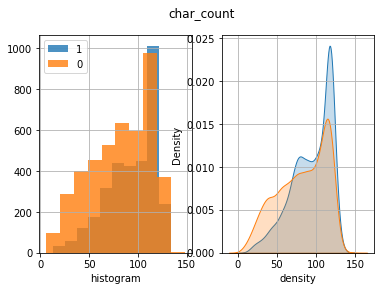

In [30]:
# to 'vizualise' behavior of each target relating to a feature

#Choose your feature
feature = "char_count"

x, y = feature, "target"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in data[y].unique():
    sns.distplot(data[data[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(data[data[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(data[y].unique())
ax[1].grid(True)
plt.show();

In [31]:
# create a dataframe that shows how important a feature is for target 1 vs target 0
# for the spacy tags 'tags_GPE','tags_FAC','tags_EVENT','tags_LOC' 
#(personal choice made on the description of those tags by stacy docs)

lst_mytag = ['tags_GPE','tags_FAC','tags_EVENT','tags_LOC']
for tag in lst_mytag:
    df_0 = pd.DataFrame(columns= [0,1], index=lst_mytag)

for tag in lst_mytag:
  for d,elem in zip(data.groupby('target')[tag].mean(), [0,1]):
      df_0.loc[tag,elem] = d

df_0['ratio'] = df_0[1]/df_0[0]
df_0

,0,1,ratio
tags_GPE,0.0907416,0.381535,4.20463
tags_FAC,0.0112851,0.036686,3.25083
tags_EVENT,0.00575772,0.00733721,1.27433
tags_LOC,0.0101336,0.0513604,5.06834


In [32]:
#create a dataframe that shows how important a feature is for target 1 vs target 0
# for all numerical features

wording_features = ['disaster_word','word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenght']
for feature in wording_features:
  df_1 = pd.DataFrame(columns= [0,1], index=wording_features)

for feature in wording_features:
  for d,elem in zip(data.groupby('target')[feature].mean(), [0,1]):
    df_1.loc[feature,elem] = d

df_1['ratio'] = df_1[1]/df_1[0]
df_1

,0,1,ratio
disaster_word,0.0428374,0.161724,3.7753
word_count,14.7239,15.2012,1.03242
char_count,82.1082,94.0352,1.14526
sentence_count,2.32474,2.81718,1.21183
avg_word_length,5.91923,6.54277,1.10534
avg_sentence_lenght,8.23347,6.966,0.846059


## 🌤  
It seems that the features having a significal impact on the target one are :
- disaster word
- tags_GPE
- tags_LOC
- tags_FAC

# Vectorize

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

column_trans = ColumnTransformer([('vec', TfidfVectorizer(ngram_range=(1,1)), 'clean_text')]
                                 , remainder='passthrough')


In [34]:
y = data['target']

# Models

## Machine Learning Models

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### MultinomialNB

In [66]:

from sklearn.naive_bayes import MultinomialNB

# Create Pipeline

pipe_MNNB = Pipeline([
    ('tfidf', column_trans),
    ('nb', MultinomialNB()),
])

# Set parameters to search (model and vectorizer)

parameters_MNNB = {
    'tfidf__vec__ngram_range': ((1,1), (2,2),(1,2)),
    'nb__alpha': (0.1,0.01,1)}

# Perform grid search on pipeline

grid_search_MNNB = GridSearchCV(pipe_MNNB, parameters_MNNB, n_jobs=-1, 
                           verbose=1, scoring = "precision", 
                           refit=False, cv=5)

grid_search_MNNB.fit(data[['clean_text','disaster_word','tags_GPE','tags_LOC','tags_FAC']],y)


print(grid_search_MNNB.best_params_)
print(f' precision : {round((grid_search_MNNB.best_score_),3)}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'nb__alpha': 1, 'tfidf__vec__ngram_range': (1, 2)}
 precision : 0.706


### Linear SVC

In [80]:
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer

#my_scorer = make_scorer(("accuracy","recall","precision"))

# Create Pipeline

pipe_svc = Pipeline([
    ('tfidf', column_trans),
    ('svc', LinearSVC()),
])

# Set parameters to search (model and vectorizer)
parameters_svc = {
    'tfidf__vec__ngram_range': ((1,1), (2,2),(1,2)),
    'svc__C': (0.1,0.01,1)}

# Perform grid search on pipeline

grid_search_svc = GridSearchCV(pipe_svc, parameters_svc, n_jobs=-1, 
                           verbose=1, scoring = "precision", 
                           refit=True, cv=5)

grid_search_svc.fit(data[['clean_text','disaster_word','tags_GPE','tags_LOC','tags_FAC']],y)


print(grid_search_svc.best_params_)
print(f' precision : {round((grid_search_svc.best_score_),3)}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'svc__C': 0.1, 'tfidf__vec__ngram_range': (1, 2)}
 precision : 0.754


### KNeighbors

In [79]:
from sklearn.neighbors import KNeighborsClassifier

# Create Pipeline

pipe_knc = Pipeline([
    ('tfidf', column_trans),
    ('knc', KNeighborsClassifier()),
])

# Set parameters to search (model and vectorizer)
parameters_knc = {
    'tfidf__vec__ngram_range': ((1,1), (2,2),(1,2)),
    'knc__n_neighbors': (2,3,4,5)}

# Perform grid search on pipeline

grid_search_knc = GridSearchCV(pipe_knc, parameters_knc, n_jobs=-1, 
                           verbose=1, scoring = "precision", 
                           refit=True, cv=5)

grid_search_knc.fit(data[['clean_text','disaster_word','tags_GPE','tags_LOC','tags_FAC']],y)


print(grid_search_knc.best_params_)
print(f' precision : {round((grid_search_knc.best_score_),3)}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'knc__n_neighbors': 3, 'tfidf__vec__ngram_range': (1, 1)}
 precision : 0.567


## 🌤  
Let's use KNN. Here I choose the precision as metric to avoid to give false alarms and focus on the prediction instead of the actual.

### Final Model

In [81]:
from sklearn.model_selection import train_test_split

#set my new column_transformer
column_transform = ColumnTransformer([('vec', TfidfVectorizer(ngram_range=(2,2)), 'clean_text')]
                                 , remainder='passthrough')

# create training data with only the wanted features
X_combined = column_transform.fit_transform(data[['clean_text','disaster_word','tags_GPE','tags_LOC']])

X_train, X_test, y_train, y_test = train_test_split(X_combined,y, test_size = 0.30, random_state=42)

In [82]:
model = KNeighborsClassifier(n_neighbors=2)
#model = LinearSVC(C=0.1)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.7180385288966725

In [83]:
# create a y_test_predicted on the train data to check with a condusion matrix that my model is not over predicted a target
y_test_predicted = model.predict(X_test)

In [84]:
from sklearn.metrics import plot_confusion_matrix

results_model = pd.DataFrame({"actual": y_test,
                           "predicted": y_test_predicted})

confusion_matrix = pd.crosstab(index= results_model['actual'],
                               columns = results_model['predicted'])


confusion_matrix

predicted,0,1
actual,,
0,1202,116
1,528,438


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


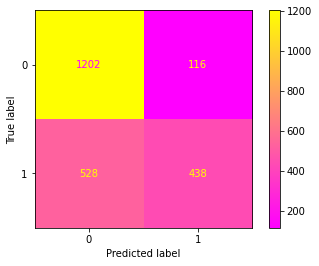

In [73]:
plot_confusion_matrix(model, X_test, y_test, cmap='spring')

In [87]:
#for the prediction, since we have a new data set, we can use all the data for the fitting
model_knn = KNeighborsClassifier(n_neighbors=2)
model_knn.fit(X_combined,y)

KNeighborsClassifier(n_neighbors=2)

## Predict

In [89]:
# transform test file to get the right features
data_test['clean_text'] = data_test['text'].apply(preprocess)
data_test['lem_text'] = data_test['clean_text'].apply(lemmatizerer)
data_test['disaster_word'] = data_test['lem_text'].apply(lambda x : count_disaster(x))
data_test = extract_stacy_tags(data_test)

# vectorize the data
X_test_combined = column_transform.transform(data_test[['clean_text','disaster_word','tags_GPE','tags_LOC','tags_FAC']])

# predict the unseen data
y_predicted = model_knn.predict(X_test_combined)

In [90]:
data_test['predicted'] = y_predicted

In [94]:
print(f'% of natural disaster spotted : {data_test["predicted"].sum()/len(data_test)}')

% of natural disaster spotted : 0.224333435488814


In [95]:
data_test[['id','keyword','location','text','predicted']].to_csv('ML_test_predicted')

# Deep Learning model

In [97]:
X_dl = data[['clean_text']]
y_dl = data['target']

In [98]:
X_dl_train, X_dl_test, y_dl_train, y_dl_test = train_test_split(X_dl, y_dl, test_size=0.30, random_state=42) 

In [99]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def text_to_word(sequence):
  return [text_to_word_sequence(_) for _ in sequence]


In [100]:
# transform string into list of words
X_dl_new = X_dl.apply(lambda x : text_to_word(x))
X_dl_train_new = X_dl_train.apply(lambda x : text_to_word(x))
X_dl_test_new = X_dl_test.apply(lambda x : text_to_word(x))

In [101]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Import Word2Vec Library to make the embedding

In [102]:
import gensim.downloader
model_twitter = gensim.downloader.load('glove-twitter-200')

In [103]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=list(X_dl_new['clean_text']), size=200, min_count=0, window=10)

In [104]:
def embedding(word2vec_transfer, word2vec_custom, file):
  new_file = []
  for list_ in file:
    embeded_sentence = []
    for word in list_:
      if word in word2vec_transfer:
        embeded_word = word2vec_transfer[word]
      else :
        embeded_word = word2vec_custom[word]
      embeded_sentence.append(embeded_word)
    new_file.append(np.array(embeded_sentence))
  return new_file

In [105]:
## Embed the training and test data
X_train_embed = embedding(model_twitter,word2vec, list(X_dl_train_new['clean_text']))
X_test_embed = embedding(model_twitter,word2vec, list(X_dl_test_new['clean_text']))

# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [106]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

model_rnn = Sequential()

model_rnn.add(layers.Masking())
model_rnn.add(layers.LSTM(36, activation='tanh',input_shape=(200,200),return_sequences=True))
model_rnn.add(layers.LSTM(16, activation='tanh', return_sequences=False))
model_rnn.add(layers.Dense(8, activation="tanh"))
model_rnn.add(layers.Dense(1, activation="sigmoid"))

model_rnn.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy','Recall','Precision'])

es = EarlyStopping(patience=10, restore_best_weights=True)

model_rnn.fit(X_train_pad, y_dl_train, validation_split=0.3, epochs=20, batch_size=16, verbose=1, callbacks=[es])

Epoch 1/20
234/234 [==============================] - 71s 255ms/step - loss: 0.4760 - accuracy: 0.7928 - recall: 0.7044 - precision: 0.7943 - val_loss: 0.5071 - val_accuracy: 0.7661 - val_recall: 0.5363 - val_precision: 0.8703
Epoch 2/20
234/234 [==============================] - 56s 241ms/step - loss: 0.4083 - accuracy: 0.8273 - recall: 0.7279 - precision: 0.8523 - val_loss: 0.4833 - val_accuracy: 0.7849 - val_recall: 0.6628 - val_precision: 0.8028
Epoch 3/20
234/234 [==============================] - 55s 237ms/step - loss: 0.3760 - accuracy: 0.8477 - recall: 0.7631 - precision: 0.8696 - val_loss: 0.4786 - val_accuracy: 0.7961 - val_recall: 0.6686 - val_precision: 0.8244
Epoch 4/20
234/234 [==============================] - 56s 240ms/step - loss: 0.3470 - accuracy: 0.8568 - recall: 0.7767 - precision: 0.8789 - val_loss: 0.4854 - val_accuracy: 0.7867 - val_recall: 0.7180 - val_precision: 0.7707
Epoch 5/20
234/234 [==============================] - 56s 241ms/step - loss: 0.3198 - accura

In [107]:
model_rnn.evaluate(X_test_pad,y_dl_test)

72/72 [==============================] - 4s 58ms/step - loss: 0.4239 - accuracy: 0.8170 - recall: 0.6977 - precision: 0.8425


[0.423895001411438, 0.8169877529144287, 0.6977225542068481, 0.8424999713897705]

### Transform data_test

In [108]:
# transform string into list of words
X_to_predict = data_test[['clean_text']].apply(lambda x : text_to_word(x))

# create a custom embedding with Word2vec
word2vec_v2 = Word2Vec(sentences=list(X_to_predict['clean_text']), size=200, min_count=0, window=10)

# apply a transfer embedding and the custmom embedding to the data
X_to_predict_embed = embedding(model_twitter,word2vec_v2, list(X_to_predict['clean_text']))

# pad the data
X_to_predict_pad = pad_sequences(X_to_predict_embed, dtype='float32', padding='post', maxlen=200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [109]:
# make the prediction
y_predicted_dl = model_rnn.predict(X_to_predict_pad)

In [110]:
#add predicted column according to a probability threshold
temp = pd.DataFrame(y_predicted_dl)
data_test_dl = pd.concat((data_test[['text']],temp), axis=1)
data_test_dl['predicted'] = 0

threshold = 0.7
data_test_dl['predicted'][data_test_dl[0] >= threshold] = 1

# save the file
data_test[['id','keyword','location','text','predicted']].to_csv('DL_test_predicted')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
